# Flight Delay Prediction I

In this project, we use the popular Flights Dataset to analyze and predict flight delays in airports based on past flight records. 
For this dataset, we will only look at the flights in 2007 - this is still 7 million flights!
In this notebook, we will build a classification model to predict airline delay from historical flight data.


In [1]:
#import some Python packages that we need:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from IPython.display import display
from ipywidgets import interact
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
%matplotlib inline

In [2]:
textFile = sc.textFile('/Users/Sally/Downloads/2007.csv')

In [3]:
#remove the header of file
textFileRDD = textFile.map(lambda x: x.split(','))
header = textFileRDD.first()

textRDD = textFileRDD.filter(lambda r: r != header)

### Creating the Dataframe from RDD

In [5]:
def parse(r):
    try:
        x=Row(Year=int(r[0]),\
          Month=int(r[1]),\
          DayofMonth=int(r[2]),\
          DayOfWeek=int(r[3]),\
          DepTime=int(float(r[4])), \
          CRSDepTime=int(r[5]),\
          ArrTime=int(float(r[6])),\
          CRSArrTime=int(r[7]), \
          UniqueCarrier=r[8],\
          DepDelay=int(float(r[15])),\
          Origin=r[16],\
          Dest=r[17], \
          Distance=int(float(r[18])),\
          CarrierDelay=int(float(r[24])),\
          WeatherDelay=int(float(r[25])),\
          NASDelay= int(float(r[26])),\
          SecurityDelay=int(float(r[27])),\
          LateAircraftDelay=int(float(r[28])))  
    except:
        x=None  
    return x

rowRDD = textRDD.map(lambda r: parse(r)).filter(lambda r:r != None)
airline_df = sqlContext.createDataFrame(rowRDD)

#### add a new column to our data frame, DepDelayed, a binary variable:
True, for flights that have > 15 minutes of delay
False, for flights that have <= 15 minutes of delay

In [6]:
airline_df = airline_df.withColumn('DepDelayed', airline_df['DepDelay']>15)

In [7]:
# define hour function to obtain hour of day
def hour_ex(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h

# register as a UDF 
f = udf(hour_ex, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
airline_df = airline_df.withColumn('hour', f(airline_df.CRSDepTime))
airline_df.registerTempTable("airlineDF")

### Exploration: What are the primary causes for flight delays

In [8]:
cause_delay = sqlContext.sql("SELECT sum(WeatherDelay) Weather,sum(NASDelay) NAS,sum(SecurityDelay) Security,sum(LateAircraftDelay) lateAircraft,sum(CarrierDelay) Carrier\
                              FROM airlineDF ")

In [9]:
df_cause_delay = cause_delay.toPandas()

In [10]:
df_cause_delay.head()

,Weather,NAS,Security,lateAircraft,Carrier
0,5739649,28200746,176906,38004942,28808434


### Exploration: Which Airports have the Most Delays?

In [7]:
groupedDelay = sqlContext.sql("SELECT Origin, count(*) conFlight,avg(DepDelay) delay \
                                FROM airlineDF \
                                GROUP BY Origin")

df_origin = groupedDelay.toPandas()

In [9]:
df_origin.sort('delay',ascending=0).head()

/Users/Sally/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Origin,conFlight,delay
272,ACK,277,51.346570
279,PIR,4,45.500000
79,SOP,185,35.859459
81,HHH,944,23.855932
175,MCN,936,23.842949


To map each Airport to corresponding Long and Lat,load the dataset needed

In [11]:
df = pd.read_csv('/Users/Sally/Downloads/airports.dat', index_col=0,\
names = ['name', 'city', 'country','IATA','ICAO','lat','lng','alt','TZone','DST','Tz'], \
            header=0)

In [22]:
df.head()

,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
2,Madang,Madang,Papua New Guinea,MAG,AYMD,-5.207083,145.788700,20,10.0,U,Pacific/Port_Moresby
3,Mount Hagen,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789,144.295861,5388,10.0,U,Pacific/Port_Moresby
4,Nadzab,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569828,146.726242,239,10.0,U,Pacific/Port_Moresby
5,Port Moresby Jacksons Intl,Port Moresby,Papua New Guinea,POM,AYPY,-9.443383,147.220050,146,10.0,U,Pacific/Port_Moresby
6,Wewak Intl,Wewak,Papua New Guinea,WWK,AYWK,-3.583828,143.669186,19,10.0,U,Pacific/Port_Moresby


In [12]:
df_airports = pd.merge(df_origin, df, left_on = 'Origin', right_on = 'IATA')

In [13]:
df_airports.head()

,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
0,IAH,197869,10.571995,George Bush Intercontinental,Houston,United States,IAH,KIAH,29.984433,-95.341442,97,-6.0,A,America/Chicago
1,RFD,688,0.585756,Chicago Rockford International Airport,Rockford,United States,RFD,KRFD,42.195361,-89.097222,742,-6.0,A,America/Chicago
2,GEG,15998,5.572322,Spokane Intl,Spokane,United States,GEG,KGEG,47.619861,-117.533833,2376,-8.0,A,America/Los_Angeles
3,YUM,3436,6.409197,Yuma Mcas Yuma Intl,Yuma,United States,YUM,KYUM,32.656578,-114.605980,216,-7.0,N,America/Phoenix
4,TUS,27827,6.169979,Tucson Intl,Tucson,United States,TUS,KTUS,32.116083,-110.941028,2643,-7.0,N,America/Phoenix


In [20]:
df_airports.sort('delay',ascending=0).head()

/Users/Sally/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
272,ACK,277,51.346570,Nantucket Mem,Nantucket,United States,ACK,KACK,41.253053,-70.060181,48,-5.0,A,America/New_York
279,PIR,4,45.500000,Pierre Regional Airport,Pierre,United States,PIR,KPIR,44.382700,-100.286000,1742,-6.0,A,America/Chicago
79,SOP,185,35.859459,Moore County Airport,Pinehurst-Southern Pines,United States,SOP,KSOP,35.237611,-79.388796,455,-5.0,A,America/New_York
81,HHH,944,23.855932,Hilton Head,Hilton Head,United States,HHH,KHHH,32.216000,-80.752000,10,-5.0,U,America/New_York
175,MCN,936,23.842949,Middle Georgia Rgnl,Macon,United States,MCN,KMCN,32.692850,-83.649211,354,-5.0,A,America/New_York


In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def zscore(x):
    return (x-np.average(x))/np.std(x)

Plot the map:

Each marker is an airport.
Size of markers: Airport Traffic (larger means higher number of flights in year)
Color of markers: Average Flight Delay (Redder means longer delays)


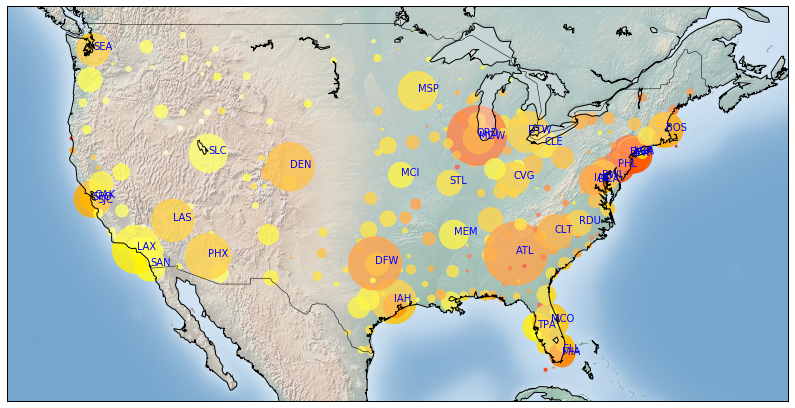

In [17]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 30))
colors=np.flipud(colors)

#----- Scatter -------
countrange=max(df_airports['conFlight'])-min(df_airports['conFlight'])
al=np.array([sigmoid(x) for x in zscore(df_airports['delay'])])
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
val=df_airports['conFlight']*4000.0/countrange

my_map.scatter(xs, ys,  marker='o', s= val, alpha = 0.8,color=colors[(al*20).astype(int)])

#----- Text -------
df_text=df_airports[(df_airports['conFlight']>60000) & (df_airports['IATA'] != 'HNL')]
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['IATA'])
zp=zip(xt,yt,txt)
for row in zp:
    #print zp[2]
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each marker is an airport.")
print("Size of markers: Airport Traffic (larger means higher number of flights in year)")
print("Color of markers: Average Flight Delay (Redder means longer delays)")

plt.show()

#### Exploration: Route delay

#### Which Routes are typically the most delayed?

In [10]:
grp_rout_Delay = sqlContext.sql("SELECT Origin, Dest, count(*) traffic,avg(Distance) avgDist,\
                                    avg(DepDelay) avgDelay\
                                FROM airlineDF \
                                GROUP BY Origin,Dest")
rout_Delay = grp_rout_Delay.toPandas()

In [23]:
df_airport_rout1 = pd.merge(rout_Delay, df, left_on = 'Origin', right_on = 'IATA')
df_airport_rout2 = pd.merge(df_airport_rout1, df, left_on = 'Dest', right_on = 'IATA')
df_airport_rout = df_airport_rout2[["Origin","lat_x","lng_x","Dest","lat_y","lng_y",\
                                    "avgDelay", "traffic"]]

In [31]:
df_airport_rout.sort('avgDelay',ascending=0).head()

/Users/Sally/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Origin,lat_x,lng_x,Dest,lat_y,lng_y,avgDelay,traffic
2670,ONT,34.056000,-117.601194,IAD,38.944533,-77.455811,386.0,1
4126,ELP,31.807250,-106.377583,MFE,26.175833,-98.238611,307.0,1
4864,ACY,39.457583,-74.577167,MYR,33.679750,-78.928333,222.0,1
3155,AVP,41.338478,-75.723403,BUF,42.940525,-78.732167,201.0,1
4297,JFK,40.639751,-73.778925,GSO,36.097750,-79.937306,173.0,1


Each line represents a route from the Origin to Destination airport.
The redder line, the higher probablity of delay.


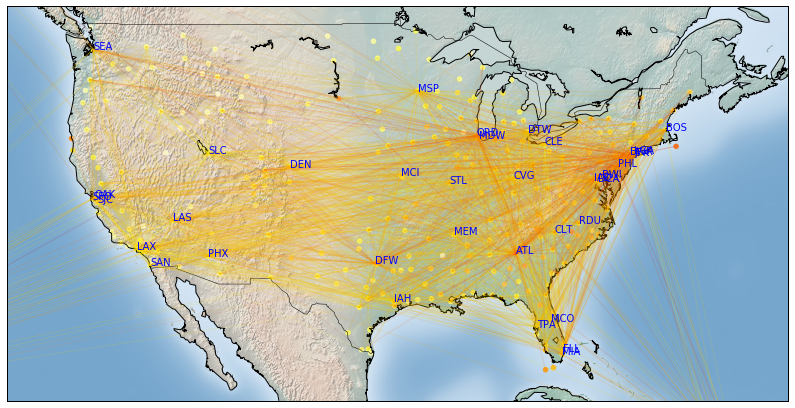

In [24]:
rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

delay=np.array([sigmoid(x) for x in zscore(df_airports["delay"])])
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 40))
colors=np.flipud(colors)
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
xo,yo = my_map(np.asarray(df_airport_rout['lng_x']), np.asarray(df_airport_rout['lat_x']))
xd,yd = my_map(np.asarray(df_airport_rout['lng_y']), np.asarray(df_airport_rout['lat_y']))

my_map.scatter(xs, ys,  marker='o',  alpha = 0.8,color=colors[(delay*20).astype(int)])


al=np.array([sigmoid(x) for x in zscore(df_airport_rout["avgDelay"])])
f=zip(xo,yo,xd,yd,df_airport_rout['avgDelay'],al)
for row in f:
    plt.plot([row[0],row[2]], [row[1],row[3]],'-',alpha=0.07, \
             color=colors[(row[5]*30).astype(int)] )
    

for row in zp:
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each line represents a route from the Origin to Destination airport.")
print("The redder line, the higher probablity of delay.")
    
plt.show()

#### Exploration: Airport Origin delay per month

In [32]:
Origin_Airport="SJC"

In [33]:
df_ORG = sqlContext.sql("SELECT * from airlineDF WHERE origin='"+ Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")
df_ORG.select('ArrTime','CRSArrTime','CRSDepTime',\
              'DayOfWeek','DayofMonth','DepDelay','DepTime','Dest').show(2)

+-------+----------+----------+---------+----------+--------+-------+----+
|ArrTime|CRSArrTime|CRSDepTime|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|
+-------+----------+----------+---------+----------+--------+-------+----+
|   1223|      1210|      1110|        2|         2|      17|   1127| BUR|
|   1551|      1555|      1455|        2|         2|       0|   1455| BUR|
+-------+----------+----------+---------+----------+--------+-------+----+
only showing top 2 rows



In [34]:
print "total flights from this ariport: " + str(df_ORG.count())

total flights from this ariport: 60959


In [35]:
grp_carr = sqlContext.sql("SELECT  UniqueCarrier,month, avg(DepDelay) avgDelay from df_ORG \
                            WHERE DepDelayed=True \
                            GROUP BY UniqueCarrier,month")
s = grp_carr.toPandas()

In [37]:
ps = s.pivot(index='month', columns='UniqueCarrier', values='avgDelay')[['AA','UA','US']]

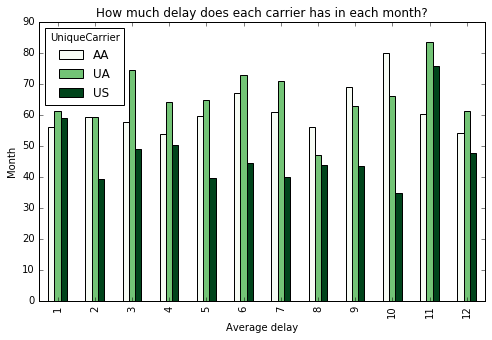

In [38]:
rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='Greens');
plt.xlabel('Average delay')
plt.ylabel('Month')
plt.title('How much delay does each carrier has in each month?')

#### We see that average delay in this year is is highest in November and October in this airport.

### Exploration: Airport Origin delay per day/hour

In [39]:
hour_grouped = df_ORG.filter(df_ORG['DepDelayed']).select('DayOfWeek','hour','DepDelay').groupby('DayOfWeek','hour').mean('DepDelay')

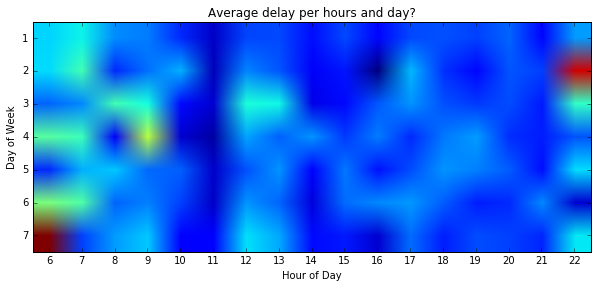

In [40]:
rcParams['figure.figsize'] = (10,5)
dh = hour_grouped.toPandas()
c = dh.pivot('DayOfWeek','hour')
X = c.columns.levels[1].values
Y = c.index.values
Z = c.values
plt.xticks(range(0,24), X)
plt.yticks(range(0,7), Y)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Average delay per hours and day?')
plt.imshow(Z)

A clear pattern here: flights tend to be delayed in these situations:

Later in the day: possibly because delays tend to pile up as the day progresses and the problem tends to compound later in the day.

Mornings in first day of week possibly because of more business meetings

## Modeling: Logistic Regression

In [44]:
# Feature selection
df_model=df_ORG
stringIndexer1 = StringIndexer(inputCol="Origin", outputCol="originIndex")
model_stringIndexer = stringIndexer1.fit(df_model)
indexedOrigin = model_stringIndexer.transform(df_model)
encoder1 = OneHotEncoder(dropLast=False, inputCol="originIndex", outputCol="originVec")
df_model = encoder1.transform(indexedOrigin)

We use labeled point to make local vectors associated with a label/response. In MLlib, labeled points are used in supervised learning algorithms and they are stored as doubles. For binary classification, a label should be either 0 (negative) or 1 (positive).

In [46]:
assembler = VectorAssembler(
    inputCols = ['Year','Month','DayofMonth','DayOfWeek','hour','Distance','originVec'],
    outputCol = "features")
output = assembler.transform(df_model)
airlineRDD=output.map(lambda row: LabeledPoint([0,1][row['DepDelayed']],row['features']))

In [47]:
#  Spliting dataset into train and test dtasets
trainRDD,testRDD=airlineRDD.randomSplit([0.7,0.3])

In [48]:
# Build the model
model = LogisticRegressionWithLBFGS.train(trainRDD)

### Model Evaluation

In [49]:
# Evaluating the model on testing data
labelsAndPreds = testRDD.map(lambda p: (p.label, model.predict(p.features)))

In [50]:
def conf(r):
    if r[0] == r[1] ==1: x= 'TP'
    if r[0] == r[1] ==0: x= 'TN'
    if r[0] == 1 and  r[1] ==0: x= 'FN'
    if r[0] == 0 and  r[1] ==1: x= 'FP'
    return (x)
acc1 = labelsAndPreds.map(lambda (v, p): ((v, p),1)).reduceByKey(lambda a, b: a + b).take(5)
acc = [(conf(x[0]),x[1]) for x in acc1]

In [51]:
TP=TN=FP=FN=0.0
for x in acc: 
    if x[0]=='TP': TP= x[1]
    if x[0]=='TN': TN= x[1]
    if x[0]=='FP': FP= x[1]
    if x[0]=='FN': FN= x[1]
eps = sys.float_info.epsilon
Accuracy = (TP+TN) / (TP + TN+ FP+FN+eps) 
print "Model Accuracy for JFK: %1.2f %%" % (Accuracy*100)

Model Accuracy for JFK: 85.13 %
